# ***Final Project - IOT Smart Parking***

**Install and Import Dependencies**

In [ ]:
# Install necessary libraries
!pip install pandas numpy scikit-learn

# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


**Load Dataset**

In [ ]:
# Load the dataset
df = pd.read_csv('IIoT_Smart_Parking_Management.csv')

# Ensure 'Timestamp' is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

print("Dataset Loaded and Timestamp converted.")
df.head()


Dataset Loaded and Timestamp converted.


,Timestamp,Parking_Spot_ID,Sensor_Reading_Proximity,Sensor_Reading_Pressure,Vehicle_Type_Weight,Vehicle_Type_Height,User_Type,Weather_Temperature,Weather_Precipitation,Nearby_Traffic_Level,...,Occupancy_Status,Vehicle_Type,Parking_Violation,Sensor_Reading_Ultrasonic,Parking_Duration,Environmental_Noise_Level,Dynamic_Pricing_Factor,Spot_Size,Proximity_To_Exit,User_Parking_History
0,2021-01-01 00:00:00.000000000,20,1.023651,1.541461,1831.770127,4.392528,Visitor,18.092553,1,Low,...,Occupied,Car,0,102.951052,4,55.620740,0.8,Standard,6.610474,6.660310
1,2021-01-02 06:39:16.756756756,49,3.903349,1.621719,1330.815754,4.595638,Registered,13.397533,0,Low,...,Occupied,Car,0,87.559131,3,56.682386,1.2,Compact,8.678719,6.766187
2,2021-01-03 13:18:33.513513513,38,10.315709,6.292374,1255.134827,4.313721,Registered,21.687410,0,High,...,Vacant,Car,1,100.061854,5,59.239322,0.8,Standard,13.795262,-0.910052
3,2021-01-04 19:57:50.270270270,31,6.588039,1.659870,1523.442919,3.567329,Visitor,18.683461,0,Medium,...,Vacant,Motorcycle,1,110.594598,2,44.545155,0.8,Standard,1.678721,10.415888
4,2021-01-06 02:37:07.027027027,8,8.213969,3.278467,1758.490837,5.145836,Visitor,19.214876,0,High,...,Occupied,Car,0,84.786963,2,48.012604,0.8,Standard,20.012252,4.355544


**Extract Time-Based Features**

In [ ]:
# Extract features from the timestamp
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

print("Time-based features extracted.")
df[['Hour', 'DayOfWeek', 'Month', 'IsWeekend']].head()


Time-based features extracted.


,Hour,DayOfWeek,Month,IsWeekend
0,0,4,1,0
1,6,5,1,1
2,13,6,1,1
3,19,0,1,0
4,2,2,1,0


**Convert Target Variable (Occupancy Status)**

In [ ]:
# Map 'Occupied' to 1 and 'Vacant' to 0
df['Occupancy_Status_Numeric'] = df['Occupancy_Status'].map({'Occupied': 1, 'Vacant': 0})

print("Converted 'Occupancy_Status' to numeric.")
df[['Occupancy_Status', 'Occupancy_Status_Numeric']].head()


Converted 'Occupancy_Status' to numeric.


,Occupancy_Status,Occupancy_Status_Numeric
0,Occupied,1
1,Occupied,1
2,Vacant,0
3,Vacant,0
4,Occupied,1


**Generate Rolling Averages & Lag Features**

In [ ]:
# Rolling average for past occupancy status
df['RollingAvg_Occupancy'] = df['Occupancy_Status_Numeric'].rolling(window=5, min_periods=1).mean()

# Create lag features for past occupancy states
df['Prev_Occupancy'] = df['Occupancy_Status_Numeric'].shift(1)
df['Prev2_Occupancy'] = df['Occupancy_Status_Numeric'].shift(2)

# Fill NaN values caused by shifting
df.fillna(0, inplace=True)

print("Rolling averages and lag features generated.")
df[['RollingAvg_Occupancy', 'Prev_Occupancy', 'Prev2_Occupancy']].head()


Rolling averages and lag features generated.


,RollingAvg_Occupancy,Prev_Occupancy,Prev2_Occupancy
0,1.000000,0.0,0.0
1,1.000000,1.0,0.0
2,0.666667,1.0,1.0
3,0.500000,0.0,1.0
4,0.600000,0.0,0.0


**Simulate Weather Data**

In [ ]:
# Simulated weather data (replace with real data if available)
df['Rainfall'] = np.random.choice([0, 1], size=len(df))  # 0 = No Rain, 1 = Rain
df['Temperature'] = np.random.randint(15, 35, size=len(df))  # Simulated temperature values

print("Simulated weather data added.")
df[['Rainfall', 'Temperature']].head()


Simulated weather data added.


,Rainfall,Temperature
0,1,34
1,1,24
2,0,31
3,0,20
4,0,32


**Compute Aggregated Features**

In [ ]:
# Calculate average occupancy per hour and per day of the week
df['Hourly_Occupancy'] = df.groupby('Hour')['Occupancy_Status_Numeric'].transform('mean')
df['Daily_Occupancy'] = df.groupby('DayOfWeek')['Occupancy_Status_Numeric'].transform('mean')

print("Aggregated occupancy features computed.")
df[['Hourly_Occupancy', 'Daily_Occupancy']].head()


Aggregated occupancy features computed.


,Hourly_Occupancy,Daily_Occupancy
0,0.604651,0.534722
1,0.642857,0.573427
2,0.585366,0.573427
3,0.428571,0.524476
4,0.658537,0.559441


**One-Hot Encoding for Categorical Features**

In [ ]:
# One-hot encode 'DayOfWeek'
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df[['DayOfWeek']])

# Add encoded columns to the DataFrame
df_encoded = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())
df = pd.concat([df, df_encoded], axis=1)

# Drop the original 'DayOfWeek' column
df.drop(columns=['DayOfWeek'], inplace=True)

print("One-hot encoding completed.")
df.head()


One-hot encoding completed.


,Timestamp,Parking_Spot_ID,Sensor_Reading_Proximity,Sensor_Reading_Pressure,Vehicle_Type_Weight,Vehicle_Type_Height,User_Type,Weather_Temperature,Weather_Precipitation,Nearby_Traffic_Level,...,Temperature,Hourly_Occupancy,Daily_Occupancy,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,2021-01-01 00:00:00.000000000,20,1.023651,1.541461,1831.770127,4.392528,Visitor,18.092553,1,Low,...,34,0.604651,0.534722,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2021-01-02 06:39:16.756756756,49,3.903349,1.621719,1330.815754,4.595638,Registered,13.397533,0,Low,...,24,0.642857,0.573427,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2021-01-03 13:18:33.513513513,38,10.315709,6.292374,1255.134827,4.313721,Registered,21.687410,0,High,...,31,0.585366,0.573427,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2021-01-04 19:57:50.270270270,31,6.588039,1.659870,1523.442919,3.567329,Visitor,18.683461,0,Medium,...,20,0.428571,0.524476,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-01-06 02:37:07.027027027,8,8.213969,3.278467,1758.490837,5.145836,Visitor,19.214876,0,High,...,32,0.658537,0.559441,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**Normalize Numerical Features**

In [ ]:
# List of numerical features to normalize
numeric_columns = ['RollingAvg_Occupancy', 'Prev_Occupancy', 'Prev2_Occupancy', 'Hourly_Occupancy', 'Daily_Occupancy', 'Temperature']

# Apply Min-Max scaling
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

print("Normalization completed.")
df[numeric_columns].head()


Normalization completed.


,RollingAvg_Occupancy,Prev_Occupancy,Prev2_Occupancy,Hourly_Occupancy,Daily_Occupancy,Temperature
0,1.000000,0.0,0.0,0.722719,0.440586,1.000000
1,1.000000,1.0,0.0,0.846154,0.745921,0.473684
2,0.666667,1.0,1.0,0.660413,0.745921,0.842105
3,0.500000,0.0,1.0,0.153846,0.359751,0.263158
4,0.600000,0.0,0.0,0.896811,0.635587,0.894737


**Save Processed Dataset**

In [ ]:
# Save the processed dataset as CSV
df.to_csv('Processed_Parking_Data.csv', index=False)

print("Feature engineering completed and saved as 'Processed_Parking_Data.csv'.")


Feature engineering completed and saved as 'Processed_Parking_Data.csv'.


***Feature Engineering Summary***

Feature engineering transforms raw data into useful features to improve model performance.

***Key Techniques Used***



*  Time-Based Features : Extracted Hour, DayOfWeek, Month, IsWeekend to capture
occupancy patterns.

*   Target Variable Transformation : Converted Occupancy_Status ("Occupied" → 1, "Vacant" → 0) for ML compatibility.

*   Rolling Averages : RollingAvg_Occupancy (window=5) to smooth fluctuations in occupancy trends.

*   Lag Features : Prev_Occupancy & Prev2_Occupancy to capture sequential dependencies.

*   Weather Features : Simulated Rainfall & Temperature to analyze weather impact on parking.

*   Aggregated Features : Hourly_Occupancy & Daily_Occupancy to capture time-based trends.

* One-Hot Encoding : Encoded DayOfWeek as binary variables for ML compatibility.


*   Feature Scaling : Applied MinMaxScaler to normalize numeric features (0 to 1 range).

**Using the Processed Parking Dataset after Feature Engineering**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, LabelEncoder # Import LabelEncoder here
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Load dataset
df = pd.read_csv('Processed_Parking_Data.csv')

# Inspect the data
print(df.head())

# Preprocessing
# Considering 'occupied_spots' is the target variable and other columns are features
# The original code used 'occupancy', which was not in the DataFrame
target_column = 'Occupancy_Status'
features = [col for col in df.columns if col != target_column and col != 'Timestamp' and df[col].dtype != object]

X = df[features].values
y = df[target_column].values

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Encode target variable to numeric using LabelEncoder
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Reshape input for RNN (samples, timesteps, features)
timesteps = 1  # Can be adjusted based on sequence dependency
X_reshaped = X_scaled.reshape((X_scaled.shape[0], timesteps, X_scaled.shape[1]))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)

# Build RNN Model
model = Sequential([
    SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(timesteps, X.shape[1])),
    Dropout(0.2),
    SimpleRNN(50, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


# Save the trained model
model.save('trained_rnn_model.h5')
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

                       Timestamp  Parking_Spot_ID  Sensor_Reading_Proximity  \
0  2021-01-01 00:00:00.000000000               20                  1.023651   
1  2021-01-02 06:39:16.756756756               49                  3.903349   
2  2021-01-03 13:18:33.513513513               38                 10.315709   
3  2021-01-04 19:57:50.270270270               31                  6.588039   
4  2021-01-06 02:37:07.027027027                8                  8.213969   

   Sensor_Reading_Pressure  Vehicle_Type_Weight  Vehicle_Type_Height  \
0                 1.541461          1831.770127             4.392528   
1                 1.621719          1330.815754             4.595638   
2                 6.292374          1255.134827             4.313721   
3                 1.659870          1523.442919             3.567329   
4                 3.278467          1758.490837             5.145836   

    User_Type  Weather_Temperature  Weather_Precipitation  \
0     Visitor            18.092

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5092 - loss: 0.6867 - val_accuracy: 0.8400 - val_loss: 0.5388
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8577 - loss: 0.4895 - val_accuracy: 1.0000 - val_loss: 0.2539
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9621 - loss: 0.2192 - val_accuracy: 1.0000 - val_loss: 0.0707
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9876 - loss: 0.1025 - val_accuracy: 1.0000 - val_loss: 0.0206
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9870 - loss: 0.0483 - val_accuracy: 1.0000 - val_loss: 0.0086
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9992 - loss: 0.0263 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9990 - loss: 0.0158 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 1.0000 - val_loss: 0.0015
Ep

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


Accuracy: 100.00%


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

Not Occupied       1.00      1.00      1.00       103
    Occupied       1.00      1.00      1.00        97

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Confusion Matrix:
[[103   0]
 [  0  97]]


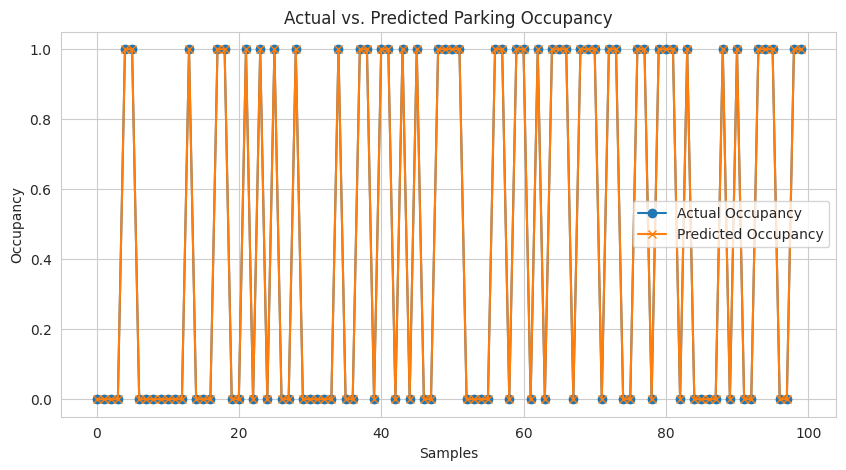

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


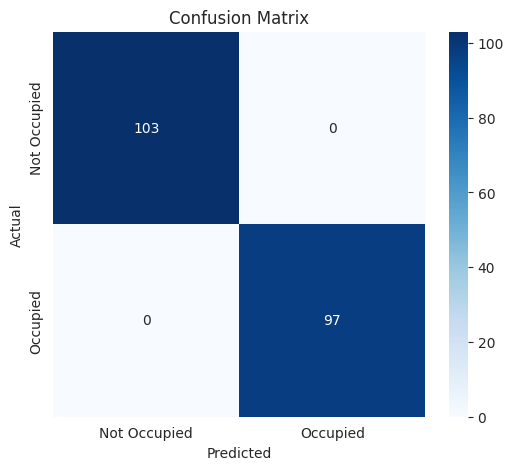

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns #Import seaborn

# Load the trained model
model = tf.keras.models.load_model('trained_rnn_model.h5')  # Ensure you save the model after training

# Load test data (Ensure test data preprocessing matches training)
X_test = np.load('X_test.npy')  # Load preprocessed test features
y_test = np.load('y_test.npy')  # Load actual labels

# Get predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Occupied', 'Occupied']))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label='Actual Occupancy', marker='o')
plt.plot(y_pred[:100], label='Predicted Occupancy', marker='x')
plt.xlabel('Samples')
plt.ylabel('Occupancy')
plt.legend()
plt.title('Actual vs. Predicted Parking Occupancy')
plt.show()

# Load the trained model
model = tf.keras.models.load_model('trained_rnn_model.h5')

# Load test data (Ensure the same preprocessing as training)
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

# Get predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Occupied', 'Occupied'], yticklabels=['Not Occupied', 'Occupied'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Training History & Actual vs Predicted Values**

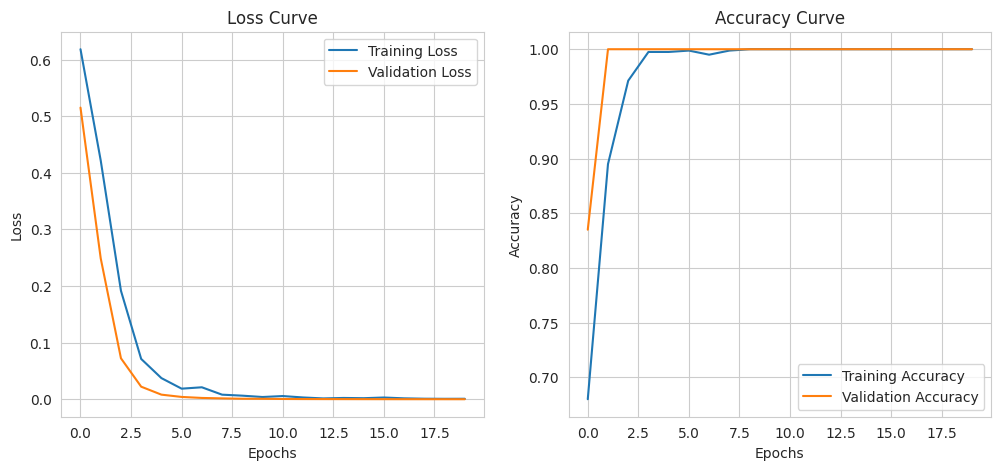

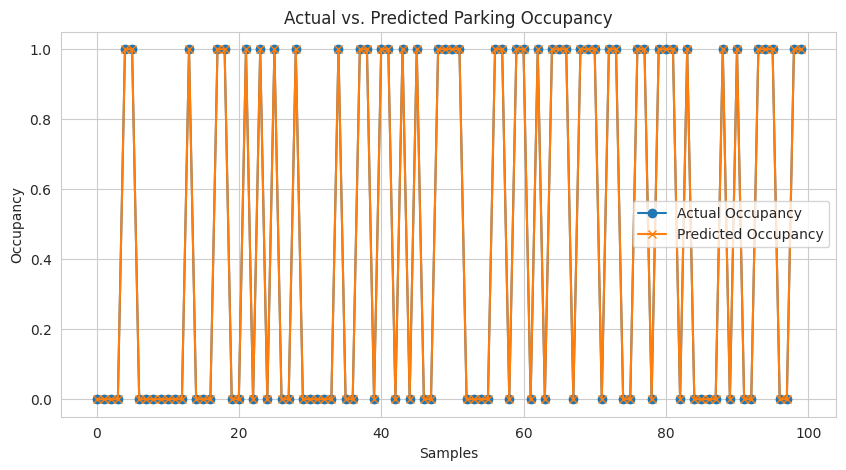

In [ ]:

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label='Actual Occupancy', marker='o')
plt.plot(y_pred[:100], label='Predicted Occupancy', marker='x')
plt.xlabel('Samples')
plt.ylabel('Occupancy')
plt.legend()
plt.title('Actual vs. Predicted Parking Occupancy')
plt.show()


**Parameter Count**

In [ ]:
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('trained_rnn_model.h5')

# Print model summary
model.summary()

# Extract parameter counts
total_params = model.count_params()
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
non_trainable_params = total_params - trainable_params

# Display parameter counts
print(f"\nTotal Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Non-Trainable Parameters: {non_trainable_params}")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ (None, 1, 50)               │           4,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,553 (37.32 KB)

 Trainable params: 9,551 (37.31 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)


Total Parameters: 9551
Trainable Parameters: 9551
Non-Trainable Parameters: 0


**Classification Report**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the trained model
model = tf.keras.models.load_model('trained_rnn_model.h5')

# Load test data (Ensure the same preprocessing as training)
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

# Get predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)


# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Occupied', 'Occupied']))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

Classification Report:
              precision    recall  f1-score   support

Not Occupied       1.00      1.00      1.00       103
    Occupied       1.00      1.00      1.00        97

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

